# Necessary Libraries

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

## Create a dataset

In [ ]:
data_dir = "/kaggle/input/dogs-vs-cats/dogs-vs-cats"

batch_size = 32
img_height = 180
img_width = 180

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 10000 files belonging to 2 classes.
Using 8000 files for training.


2022-12-28 23:23:33.312524: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [ ]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 10000 files belonging to 2 classes.
Using 2000 files for validation.


In [ ]:
class_names = train_ds.class_names
print(class_names)

['cat', 'dog']


# Visualize the data

2022-12-28 23:23:35.285129: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


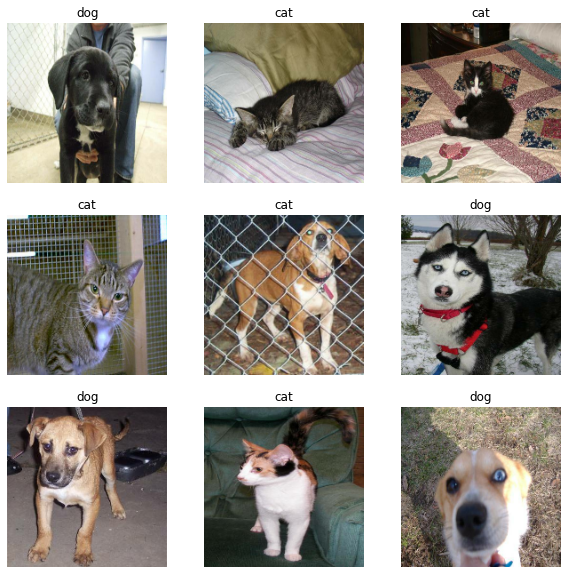

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

# Configure the dataset for performance

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Standardize the data

In [ ]:
normalization_layer = layers.Rescaling(1./255)

In [ ]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]

# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

2022-12-28 23:23:47.558766: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 224 of 1000


0.0 1.0


2022-12-28 23:23:48.392284: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


# A basic Keras model

## Create the model

In [ ]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

## Compile the model

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

## Model summary

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 64)        0

## Train the model

In [ ]:
epochs=10

history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
250/250 [==============================] - 64s 254ms/step - loss: 0.6567 - accuracy: 0.6194 - val_loss: 0.5980 - val_accuracy: 0.6790
Epoch 2/10
250/250 [==============================] - 61s 243ms/step - loss: 0.5497 - accuracy: 0.7182 - val_loss: 0.5258 - val_accuracy: 0.7395
Epoch 3/10
250/250 [==============================] - 60s 241ms/step - loss: 0.4893 - accuracy: 0.7615 - val_loss: 0.5568 - val_accuracy: 0.7380
Epoch 4/10
250/250 [==============================] - 60s 242ms/step - loss: 0.4174 - accuracy: 0.8085 - val_loss: 0.5192 - val_accuracy: 0.7515
Epoch 5/10
250/250 [==============================] - 61s 244ms/step - loss: 0.3241 - accuracy: 0.8525 - val_loss: 0.5390 - val_accuracy: 0.7620
Epoch 6/10
250/250 [==============================] - 61s 243ms/step - loss: 0.2123 - accuracy: 0.9096 - val_loss: 0.6769 - val_accuracy: 0.7570
Epoch 7/10
250/250 [==============================] - 60s 240ms/step - loss: 0.1099 - accuracy: 0.9586 - val_loss: 0.7935 - val_ac

# Visualize training results

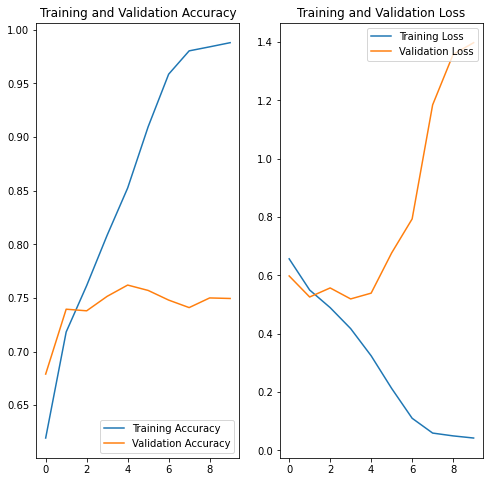

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Overfitting

The plots above show that the training accuracy is steadily increasing over time, while the validation accuracy plateaued around 60% during the training process. This discrepancy between the two accuracies is a sign of overfitting, where the model is too closely fitting the patterns in the training data and is not generalizing well to new, unseen data.

Overfitting can occur when there are a small number of training examples and the model learns from noise or unwanted details in the training data, leading to poor performance on new data. To combat overfitting, we can use techniques like data augmentation and dropout during the training process.

# Data augmentation

In [ ]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

To get a sense of how data augmentation works, you can apply various random transformations to the same image multiple times and visualize the resulting augmented images.

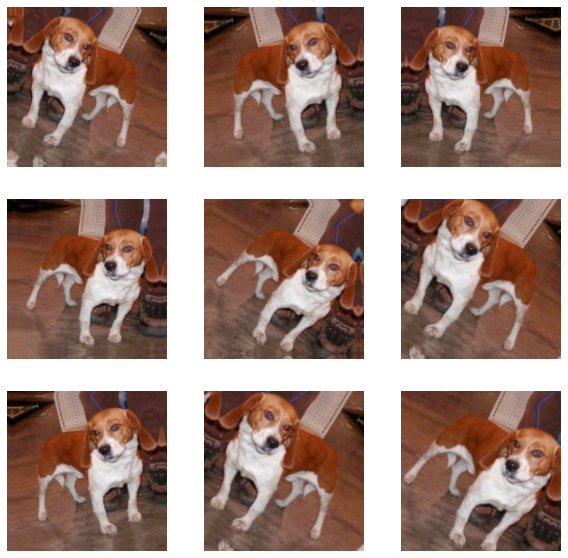

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In the next step, you will incorporate data augmentation into your model prior to training.

# Dropout

To further reduce the risk of overfitting, you can add dropout regularization to your network. Dropout works by randomly setting a fraction of the output units of a layer to zero during the training process. For example, you can specify a dropout rate of 0.1, which means that 10% of the units in the layer will be randomly dropped out during training.

To incorporate dropout into your model, you can use the Dropout layer in Keras. Before training your model, you can add this layer to your network and specify the dropout rate that you want to use.

In [ ]:
model = Sequential([
  data_augmentation, # <= image augmentation
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2), # <= before training
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

# Compile and train the model

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling_2 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 45, 45, 64)       

In [ ]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
250/250 [==============================] - 83s 327ms/step - loss: 0.6789 - accuracy: 0.5810 - val_loss: 0.6625 - val_accuracy: 0.6020
Epoch 2/15
250/250 [==============================] - 82s 329ms/step - loss: 0.6251 - accuracy: 0.6553 - val_loss: 0.6100 - val_accuracy: 0.6725
Epoch 3/15
250/250 [==============================] - 81s 325ms/step - loss: 0.5821 - accuracy: 0.7003 - val_loss: 0.5393 - val_accuracy: 0.7410
Epoch 4/15
250/250 [==============================] - 82s 328ms/step - loss: 0.5476 - accuracy: 0.7278 - val_loss: 0.5464 - val_accuracy: 0.7305
Epoch 5/15
250/250 [==============================] - 81s 323ms/step - loss: 0.5235 - accuracy: 0.7408 - val_loss: 0.5038 - val_accuracy: 0.7610
Epoch 6/15
250/250 [==============================] - 82s 327ms/step - loss: 0.5008 - accuracy: 0.7577 - val_loss: 0.4731 - val_accuracy: 0.7825
Epoch 7/15
250/250 [==============================] - 82s 327ms/step - loss: 0.4766 - accuracy: 0.7709 - val_loss: 0.4500 - val_ac

# Visualize training results

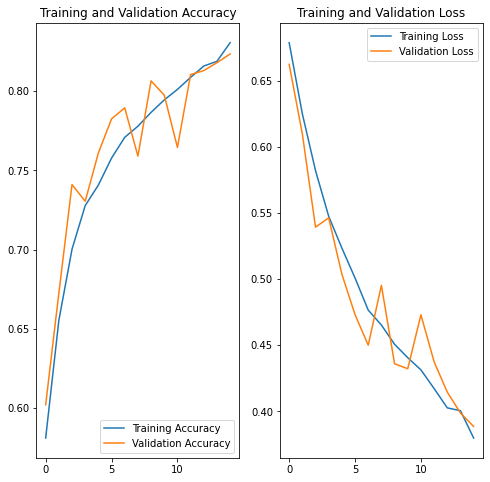

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Predict on new data

Use your trained model to classify an image that was not used in the training or validation process.

In [ ]:
unseen_cat_path = "/kaggle/input/dogs-vs-cats/unseen-cat.jpeg"
unseen_dog_path = "/kaggle/input/dogs-vs-cats/unseen-dog.jpg"

img_to_predict_path = unseen_cat_path

img = tf.keras.utils.load_img(
    img_to_predict_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to '{}' with a '{:.2f}%' confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to 'cat' with a '97.68%' confidence.
